In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K

import warnings
warnings.filterwarnings("ignore")

2025-04-05 19:30:25.314333: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 19:30:25.561846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743881425.622061   47358 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743881425.637745   47358 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743881425.827604   47358 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Path to the dataset
data_path = "/teamspace/studios/this_studio/data/segmentation"

# Tumor classes
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Initializing lists to store images, masks, and labels
images = []
masks = []
labels = []

# Desired dimensions for images and masks
target_size = (128, 128)

# Loading images and masks
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))
    mask_folder = os.path.join(data_path, 'mask', str(classes.index(class_name)))
    
    # Check if the folders exist
    if os.path.exists(image_folder) and os.path.exists(mask_folder):
        # Load images
        for image_name in tqdm(os.listdir(image_folder), desc=class_name):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Check file format
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size)
                image = image / 255.0  # Normalize pixel values
                
                # Check for the corresponding mask name
                mask_name = image_name.replace('.jpg', '_m.jpg').replace('.png', '_m.png')
                mask_path = os.path.join(mask_folder, mask_name)

                # Load the mask only if it exists
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, target_size)
                    mask = mask / 255.0  # Normalize pixel values
                    
                    # Add image and mask to the lists
                    images.append(image)
                    masks.append(mask)
                    labels.append(classes.index(class_name))
                else:
                    print(f"Missing mask for image: {image_name}")

# Convert the lists into NumPy arrays
images = np.array(images).reshape(-1, 128, 128, 1)
masks = np.array(masks).reshape(-1, 128, 128, 1)
labels = np.array(labels)

# Display the dimensions of the datasets
print(f"Number of images: {len(images)}, Number of masks: {len(masks)}, Number of labels: {len(labels)}")

no_tumor:   0%|          | 0/1595 [00:00<?, ?it/s]

glioma_tumor:   0%|          | 0/649 [00:00<?, ?it/s]

meningioma_tumor:   0%|          | 0/999 [00:00<?, ?it/s]

pituitary_tumor:   0%|          | 0/994 [00:00<?, ?it/s]

Number of images: 4237, Number of masks: 4237, Number of labels: 4237


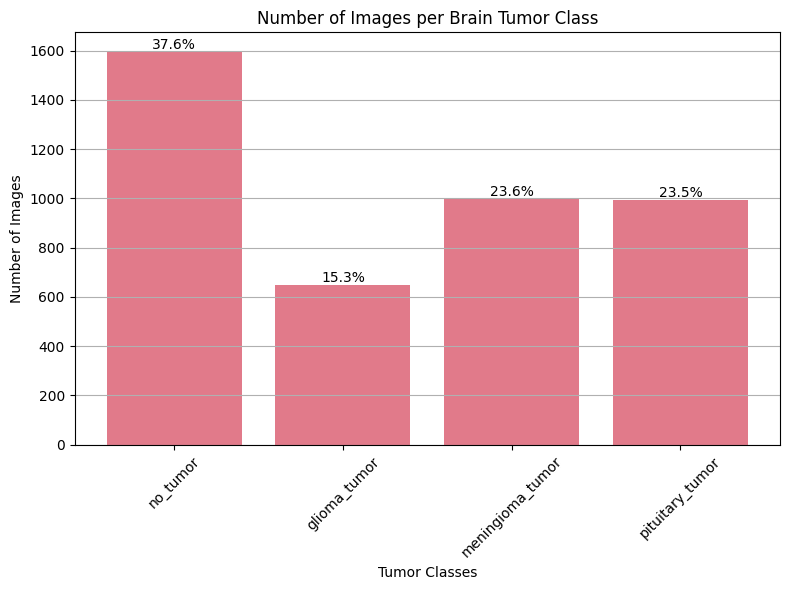

In [ ]:
# Count the number of images per class
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))

# Calculate the total number of images and the percentage per class
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='#E17A8A')

# Add percentage labels above the bars
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Tumor Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Brain Tumor Class')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()

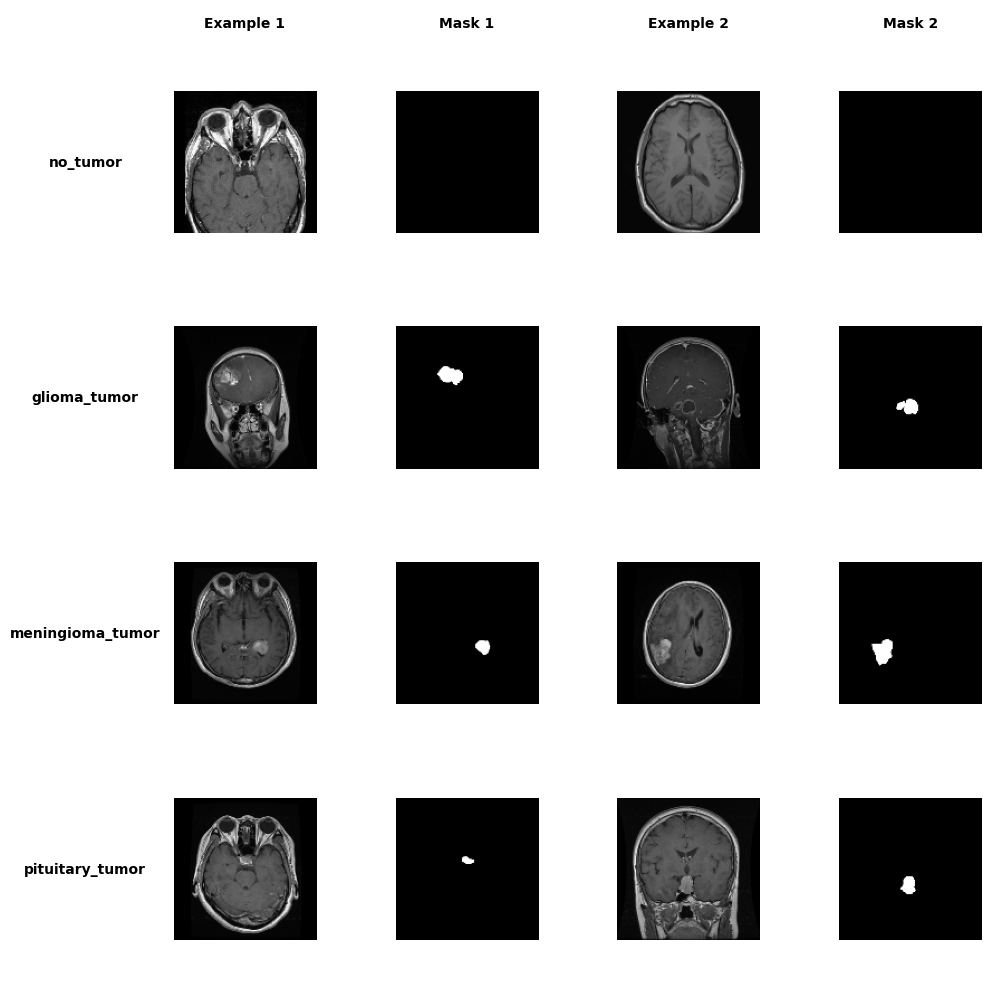

In [ ]:
# Initialize the figure with a grid for 4 classes
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(10, 10), 
                        gridspec_kw={'width_ratios': [0.5, 4, 4, 4 ,4], 'height_ratios': [0.5, 4, 4, 4, 4]})

# Column titles
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')  # Remove axes

axs[0, 1].text(0.5, 0.5, "Example 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')  # Remove axes

axs[0, 2].text(0.5, 0.5, "Mask 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')  # Remove axes

axs[0, 3].text(0.5, 0.5, "Example 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')  # Remove axes

axs[0, 4].text(0.5, 0.5, "Mask 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')  # Remove axes

for i, class_name in enumerate(classes):
    # Find image and mask indices for each class
    class_index = classes.index(class_name)
    
    # Get sample images and masks for each class
    example_index1 = np.where(labels == class_index)[0][0]  # Take the first sample of each class
    example_index2 = np.where(labels == class_index)[0][2]  # Take the second sample
    image1 = images[example_index1]
    mask1 = masks[example_index1]
    
    image2 = images[example_index2]
    mask2 = masks[example_index2]
    
    # Display the first image
    axs[i + 1, 1].imshow(image1, cmap='gray')
    axs[i + 1, 1].axis('off')  # Remove axes

    # Display the first mask
    axs[i + 1, 2].imshow(mask1, cmap='gray')
    axs[i + 1, 2].axis('off')  # Remove axes
    
    # Display the second image
    axs[i + 1, 3].imshow(image2, cmap='gray')
    axs[i + 1, 3].axis('off')  # Remove axes

    # Display the second mask
    axs[i + 1, 4].imshow(mask2, cmap='gray')
    axs[i + 1, 4].axis('off')  # Remove axes

    # Center and display the class name in the first column
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')  # Remove axes

plt.tight_layout()
plt.show()

In [ ]:
# Split the data into training set (70%) and validation set (30%)
images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
    images, masks, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True
)

# Display the shapes of the datasets
print(f"Training Set - Images: {images_train.shape}, Masks: {masks_train.shape}, Labels: {labels_train.shape}")
print(f"Validation Set - Images: {images_val.shape}, Masks: {masks_val.shape}, Labels: {labels_val.shape}")

Training Set - Images: (2965, 128, 128, 1), Masks: (2965, 128, 128, 1), Labels: (2965,)
Validation Set - Images: (1272, 128, 128, 1), Masks: (1272, 128, 128, 1), Labels: (1272,)


In [6]:
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)
    
    while True:
        img_batch = next(image_generator)  
        mask_batch = next(mask_generator)  
        
        yield img_batch, mask_batch


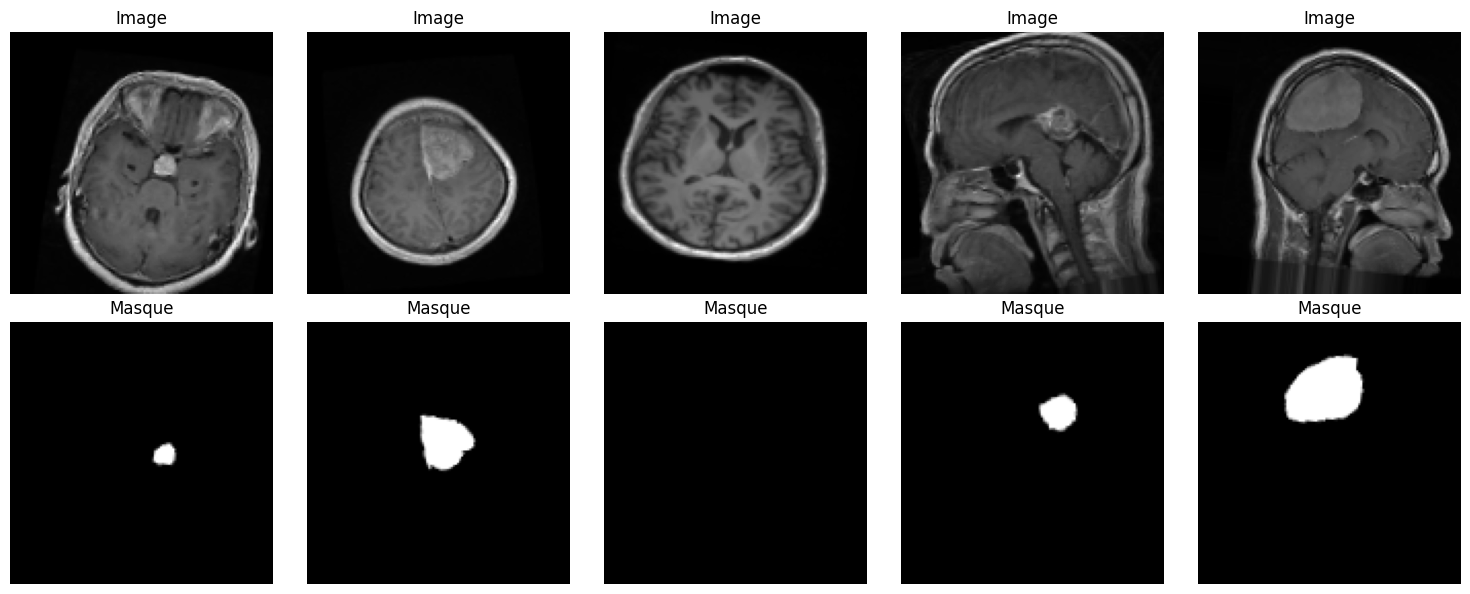

In [7]:
# Function to display images and their corresponding masks
def plot_images(images, masks, num_images=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Display the image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')  # Adjust the shape if necessary
        plt.axis('off')
        plt.title('Image')

        # Display the corresponding mask
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')  # Adjust the shape if necessary
        plt.axis('off')
        plt.title('Mask')
    
    plt.tight_layout()
    plt.show()

# Test the data augmentation generator by taking a few images
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))

# Display the images and masks
plot_images(images_batch, masks_batch, num_images=5)

In [8]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (to be used as the loss function)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# Intersection over Union (IoU)
def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)

In [9]:
# Define the U-Net model
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Create the model
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

# Define the input shape (height, width, channels)
input_shape = (128, 128, 1) 
model = unet_model(input_shape)
model.summary()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient, iou]
)

I0000 00:00:1743874684.862354   24184 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(device)

/GPU:0


In [12]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
with tf.device(device):
    # Define callbacks
    model_checkpoint = ModelCheckpoint(
        'best_unetmodel.keras',  # File name to save the best model
        monitor='val_dice_coefficient',  # Monitor the validation Dice Coefficient
        save_best_only=True,  # Save only the best model
        mode='max',  # Maximize the monitored value
        verbose=1  # Print a message when saving
    )

    early_stopping = EarlyStopping(
        monitor='val_dice_coefficient',
        patience=10,  # Stop after 10 epochs without improvement
        mode='max',  # Maximize the monitored value
        verbose=1  # Print a message when stopping
    )

    # Use the augmentation generator for training
    batch_size = 32
    train_gen = train_generator(images_train, masks_train, batch_size=batch_size)

    # Train the model using the generator
    history = model.fit(
        train_gen,
        steps_per_epoch=len(images_train) // batch_size,
        epochs=100,
        validation_data=(images_val, masks_val),
        callbacks=[model_checkpoint, early_stopping]
    )

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9855 - dice_coefficient: 0.0414 - iou: 0.0212 - loss: 0.0448

2025-04-05 17:43:33.291966: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 83361792 exceeds 10% of free system memory.



Epoch 1: val_dice_coefficient improved from -inf to 0.06014, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 516ms/step - accuracy: 0.9855 - dice_coefficient: 0.0414 - iou: 0.0212 - loss: 0.0448 - val_accuracy: 0.9870 - val_dice_coefficient: 0.0601 - val_iou: 0.0311 - val_loss: 0.0458
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9851 - dice_coefficient: 0.0483 - iou: 0.0248 - loss: 0.0447
Epoch 2: val_dice_coefficient improved from 0.06014 to 0.07312, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 503ms/step - accuracy: 0.9851 - dice_coefficient: 0.0483 - iou: 0.0248 - loss: 0.0447 - val_accuracy: 0.9870 - val_dice_coefficient: 0.0731 - val_iou: 0.0380 - val_loss: 0.0437
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9853 - dice_coefficient: 0.0615 - iou: 0.0319 - loss: 0.0425
Epoch 3: val_dice_coefficient did not improve from 0.07312
92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 489ms/step - accuracy: 0.9853 - dice_c

# Evaluation

In [13]:
# Evaluate the model on the training set
train_loss, train_accuracy, train_dice_coef, train_iou_coef = model.evaluate(images_train, masks_train, verbose=1)
print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Dice Coefficient: {train_dice_coef:.4f}')
print(f'Training IoU Coefficient: {train_iou_coef:.4f}')

92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9947 - dice_coefficient: 0.8785 - iou: 0.7838 - loss: 0.0042

2025-04-05 18:44:25.306901: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.57 = (f32[21,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,1,128,128]{3,2,1,0} %bitcast.1083, f32[64,1,3,3]{3,2,1,0} %bitcast.1090, f32[64]{0} %bitcast.1092), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-04-05 18:44:25.333072: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc

93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 267ms/step - accuracy: 0.9947 - dice_coefficient: 0.8784 - iou: 0.7837 - loss: 0.0042
Training Loss: 0.0043
Training Accuracy: 0.9949
Training Dice Coefficient: 0.8753
Training IoU Coefficient: 0.7790


In [15]:
# Evaluate the model on the validation set
val_loss, val_accuracy, val_dice_coef, val_iou_coef = model.evaluate(images_val, masks_val, verbose=1)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Dice Coefficient: {val_dice_coef:.4f}')
print(f'Validation IoU Coefficient: {val_iou_coef:.4f}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9941 - dice_coefficient: 0.8459 - iou: 0.7355 - loss: 0.0074
Validation Loss: 0.0088
Validation Accuracy: 0.9940
Validation Dice Coefficient: 0.8406
Validation IoU Coefficient: 0.7282


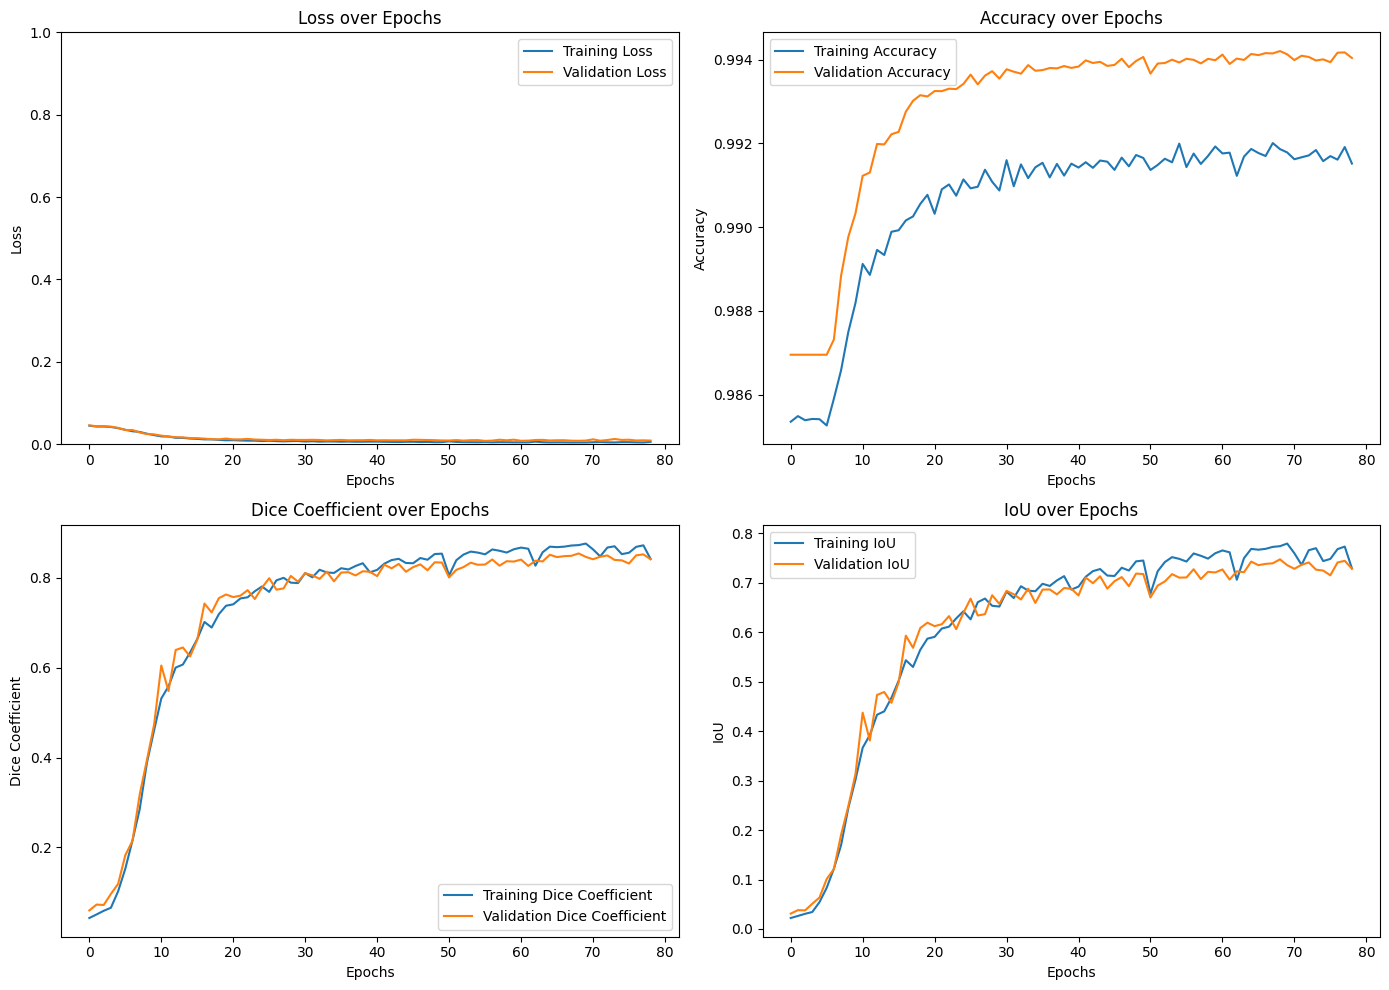

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot Loss curve
axs[0, 0].plot(history.history['loss'], label='Training Loss')
axs[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Loss over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].legend()

# Plot Accuracy curve
axs[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axs[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0, 1].set_title('Accuracy over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].legend()

# Plot Dice Coefficient curve
axs[1, 0].plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
axs[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
axs[1, 0].set_title('Dice Coefficient over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Dice Coefficient')
axs[1, 0].legend()

# Plot IoU curve
axs[1, 1].plot(history.history['iou'], label='Training IoU')
axs[1, 1].plot(history.history['val_iou'], label='Validation IoU')
axs[1, 1].set_title('IoU over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IoU')
axs[1, 1].legend()

# Adjust layout spacing
plt.tight_layout()
plt.show()